# Rainfall Generator

Weather data is ubiquitous and important for most daily activities. In agriculture, weather plays a preponderant role since it dictates the growth and eventual crop yield (fiber, biomass, or grain).

Air temperature and precipitation are by far the most commonly monitored variables, followed by relative humidity, wind speed and direccion, solar radiation, soil temperature, and soil moisture.

We will create a weather generator to generate daily minimum and maximum air temperature and precipitation scenarios. To understand the process we will examine long-term data for a specific location. Based on the trends we will build the weather generator.

> This weather generator is for teaching purposes only and lacks the statistical rigor of research tools. The exercise is only intended as a primer for students learning how to creating simple scripts using random modules. For more advanced tools, please visit the references section.


In [177]:
# Import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import gamma
from scipy.optimize import curve_fit


In [178]:
# Load sample data
df = pd.read_csv("../datasets/KS_Manhattan_6_SSW.csv")
df.head()


,WBANNO,LST_DATE,CRX_VN,LONGITUDE,LATITUDE,T_DAILY_MAX,T_DAILY_MIN,T_DAILY_MEAN,T_DAILY_AVG,P_DAILY_CALC,...,SOIL_MOISTURE_5_DAILY,SOIL_MOISTURE_10_DAILY,SOIL_MOISTURE_20_DAILY,SOIL_MOISTURE_50_DAILY,SOIL_MOISTURE_100_DAILY,SOIL_TEMP_5_DAILY,SOIL_TEMP_10_DAILY,SOIL_TEMP_20_DAILY,SOIL_TEMP_50_DAILY,SOIL_TEMP_100_DAILY
0,53974,20031001,1.201,-96.61,39.1,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,...,-99.0,-99.0,-99.0,-99,-99,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0
1,53974,20031002,1.201,-96.61,39.1,18.9,2.5,10.7,11.7,0.0,...,-99.0,-99.0,-99.0,-99,-99,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0
2,53974,20031003,1.201,-96.61,39.1,22.6,8.1,15.4,14.8,0.0,...,-99.0,-99.0,-99.0,-99,-99,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0
3,53974,20031004,1.201,-96.61,39.1,22.6,3.8,13.2,14.0,0.0,...,-99.0,-99.0,-99.0,-99,-99,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0
4,53974,20031005,1.201,-96.61,39.1,25.0,10.6,17.8,17.3,0.0,...,-99.0,-99.0,-99.0,-99,-99,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0


In [179]:
# Convert date string to pandas datetime format
df["LST_DATE"] = pd.to_datetime(df["LST_DATE"], format="%Y%m%d")
df["LST_DATE"].head() # CHeck our conversion.


0   2003-10-01
1   2003-10-02
2   2003-10-03
3   2003-10-04
4   2003-10-05
Name: LST_DATE, dtype: datetime64[ns]

In [180]:
# Convert missing values represented as -9999 to NaN
df[df == -9999] = np.nan


In [181]:
# Add year, month, and day of the year to summarize data in future steps.
df["YEAR"] = df["LST_DATE"].dt.year
df["MONTH"] = df["LST_DATE"].dt.month
df["DOY"] = df["LST_DATE"].dt.dayofyear


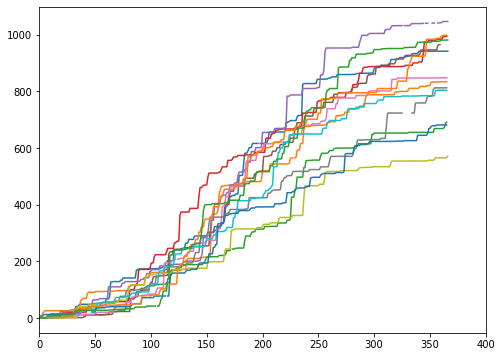

In [152]:
# Observe trends in precipitation data (2004 to 2016)
plt.figure(figsize=(8,6))
plt.xlim(0,400)
for year in range(2004,2017):
    idx_year = df["YEAR"] == year
    cdf = df["P_DAILY_CALC"][idx_year].cumsum()
    plt.plot(range(1,len(cdf)+1),cdf)
    #plt.annotate(str(year), xy=(370,cdf.values[-1]))
    

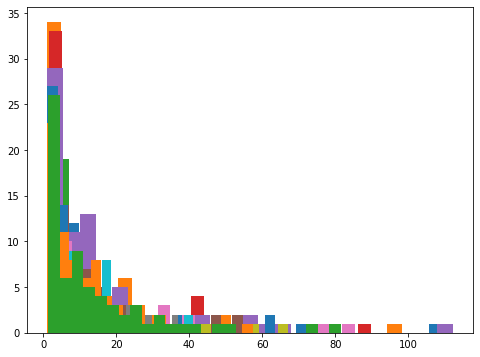

In [173]:
# Observe histograms of precipitation

plt.figure(figsize=(8,6))
for year in range(2004,2017):
    idx_year = df["YEAR"] == year
    rainfall_year = df["P_DAILY_CALC"][idx_year]
    rainfall_year = rainfall_year[rainfall_year > 1]
    plt.hist(rainfall_year, bins=25)


## Modeling rainfall as a Markov chain. 

This type of rainfall generators is kwnon as the Richardson-type (Richardson and Wright, 1984). The model computes the rainfall at time *t* as a function of time *t-1* in three steps. 

To be consistent with the original manuscript by Richardson and Wright, 1984 we will use the term "wet" for a day with measurable rainfall and "dry" for a day without measurable rainfall.

**Step 1**: Find if the previous (i.e. *t-1*) day was dry (no measurable rainfall) or wet (some measurable rainfall)

**Step 2**: Then compute the probability of having a rainfall event on day *t* given the condition on the previous day. So, here we need to have two different probability values, one that we will use if yesterday was dry, and another if yesterday was wet. 

- What is the probability of having a wet day if yesterday was dry? (i.e. P(W/D) )

- What is the probability of having a wet day if yesterday was wet? (i.e. P(W/W) )

As you can see if we only use two values and we are generating rainfall for a long period, then may not accurately simulate seasonal rainfall trends. TO solve this some models use Wet-Dry and Wet-Wet on a monthly basis. In this step we generate a yes/no answer. We will deal with the amount in the next step. 

**Step 3**: If as a consequence of the random process we obtain that on day *t* there is a rainfall event, then we have to compute the amount. To do this we will use a gamma distribution, which is suited to heavily skewed distributions, such as those resulting from histograms of daily rainfall. Again, here we probably want to have some parameters that describe this distribution at least on a monthly basis to capture the seasonal effects on rainfall amounts.


We will first run an example using the loaded dataset to learn how to compute the Wet-Dry and Wet-Wet probabilities for the entire year. It's important that we first learn how to compute the simplest step before moving into a more detailed characterization of the rainfall process on a monthly basis.


In [182]:
# Rainfall probability Wet-Dry and Wet-Wet
WW = []
WD = []
month_WW = []
month_WD = []

# Extract variables from DataFrame to sherten variable names
months = df["MONTH"]
rainfall = df["P_DAILY_CALC"]

for i in range(1,df.shape[0]):
    if rainfall[i-1] > 0:
        
        # Get current month
        month_WW.append(months[i])
        
        if rainfall[i] > 0:
            WW.append(1)
        else:
            WW.append(0)
    
    elif rainfall[i-1] == 0:
        
        month_WD.append(months[i])
        if rainfall[i] > 0:
            WD.append(1)
        else:
            WD.append(0)

print(sum(WW)/len(WW))
print(sum(WD)/len(WD))


0.4166666666666667
0.20590604026845638


In [183]:
# Wet/Wet
df_WW = pd.DataFrame([month_WW,WW]).T
df_WW.columns = ["month","WW"]
df_WW.tail(5)


,month,WW
1315,9,0
1316,9,0
1317,9,1
1318,9,0
1319,10,1


In [184]:
# Wet/Dry
df_WD = pd.DataFrame([month_WD, WD]).T
df_WD.columns = ["month","WD"]
df_WD.tail(5)


,month,WD
3720,9,0
3721,9,0
3722,10,0
3723,10,0
3724,10,1


## Daily rainfall probability per month

In [185]:
# Compute monthly probabilities per month
monthly_WW = df_WW.groupby("month").sum()/df_WW.groupby("month").count()
monthly_WD = df_WD.groupby("month").sum()/df_WD.groupby("month").count()


In [186]:
# Create table of parameters
coeff = pd.concat([monthly_WW, monthly_WD], axis=1)
coeff


,WW,WD
month,,
1,0.338028,0.141176
2,0.320513,0.161184
3,0.401709,0.219048
4,0.503448,0.273063
5,0.480769,0.290909
6,0.442953,0.293680
7,0.415254,0.228571
8,0.412214,0.245847
9,0.362745,0.201258


## Daily rainfall amount probability

In [187]:
# Fit gamma distribution to each month
monthly_shape = []
monthly_scale = []
unique_months = list(range(1,13))
for m in unique_months:
    idx_month = df["MONTH"] == m
    x = df["P_DAILY_CALC"].loc[idx_month]
    x = x[~np.isnan(x)]
    x = x[x>0]
    shape, loc, scale = gamma.fit(x, floc=0)
    monthly_shape.append(shape)
    monthly_scale.append(scale)


In [188]:
# Append amount parameters to monthly lookup table
coeff["shape"] = monthly_shape
coeff["scale"] = monthly_scale
coeff.head(12)


,WW,WD,shape,scale
month,,,,
1,0.338028,0.141176,0.748257,4.166760
2,0.320513,0.161184,0.678656,8.142081
3,0.401709,0.219048,0.632519,11.092325
4,0.503448,0.273063,0.589697,15.483557
5,0.480769,0.290909,0.630033,13.661336
6,0.442953,0.293680,0.599585,22.291664
7,0.415254,0.228571,0.677182,16.648971
8,0.412214,0.245847,0.625811,21.885339
9,0.362745,0.201258,0.585308,15.593047


Check that our gamma function can generate sound rainfall distributions. Note that the figure below is the pdf function, not the actual rainfall. The y-axis contains density information, while the x-axis contains rainfall data.

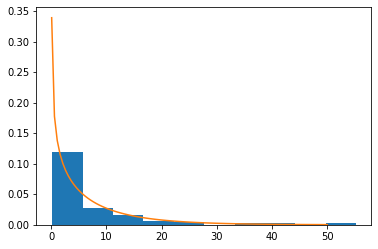

In [189]:
# Demonstrate distribution of rainfall amount distribution for last month of fitting
a,b,c = gamma.fit(x, floc=0)
plt.hist(x, density=True)
plt.plot(np.linspace(0.1,50,100), gamma.pdf(np.linspace(0.1,50,100),a,b,c))
plt.show()


## Build simulator

In [190]:
# Define rainfall simulator
def rainfall_gen(dates,coeff):
    
    P = np.ones(dates.shape[0])*np.nan
    P[0] = 0

    for t in range(1,dates.shape[0]):
        month = dates.month[t]
        if P[t-1] == 0:
            if np.random.rand() > coeff["WD"][month]:
                P[t] = 0
            else:
                P[t] = gamma.rvs(coeff["shape"][month],0,coeff["scale"][month])
                P[t] = np.round(P[t]*10)/10

        elif P[t-1] > 0:
            if np.random.rand() > coeff["WW"][month]:
                P[t] = 0
            else:
                P[t] = gamma.rvs(coeff["shape"][month],0,coeff["scale"][month])
                P[t] = np.round(P[t]*10)/10

    P_total = P.sum()
    return P


## Create rainfall scenarios

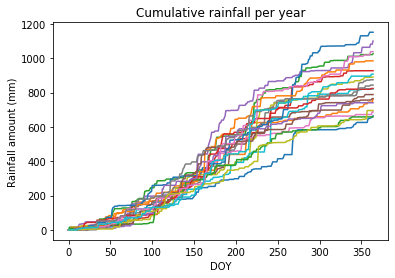

In [193]:
# Create an example set of dates
dates = pd.date_range("1-jan-2018","31-dec-2018",freq="D")

# Call rainfall generator multiple times and plot cumulative rainfall
for i in range(20):
    P = rainfall_gen(dates,coeff)
    #print("Total rainfall",round(P.sum()))
    plt.plot(P.cumsum())
    
plt.title("Cumulative rainfall per year")
plt.xlabel("DOY")
plt.ylabel("Rainfall amount (mm)")
plt.show()


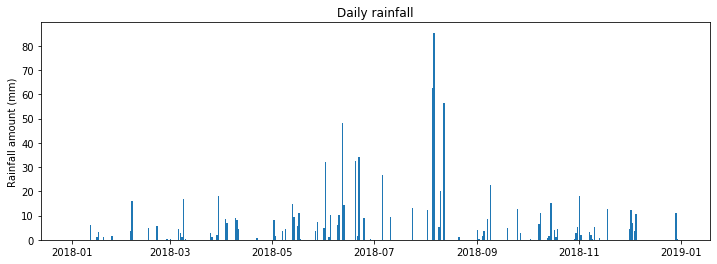

In [195]:
# Plot the last iteration
plt.figure(figsize=(12,4))
plt.bar(dates,P)
plt.title("Daily rainfall") # for last year of the previous simulation
plt.ylabel("Rainfall amount (mm)")
plt.show()


## References

Intergernmental Panel on Climate Change Data Distribution Centre: https://www.ipcc-data.org/guidelines/pages/weather_generators.html

Jones, P., Harpham, C., Kilsby, C., Glenis, V. and Burton, A., 2010. UK Climate Projections science report: Projections of future daily climate for the UK from the Weather Generator.

Kilsby, C.G., Jones, P.D., Burton, A., Ford, A.C., Fowler, H.J., Harpham, C., James, P., Smith, A. and Wilby, R.L., 2007. A daily weather generator for use in climate change studies. Environmental Modelling & Software, 22(12), pp.1705-1719.

Richardson, C.W., 1982. Dependence structure of daily temperature and solar radiation. Transactions of the ASAE, 25(3), pp.735-0739.

Richardson, C.W. and Wright, D.A., 1984. WGEN: A model for generating daily weather variables.